In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
import nltk
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Embedding, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
path = kagglehub.dataset_download("mohamad1dehqani/persian-spam-email")
file_path = path + '/emails.csv'

## 1.1) Dataset

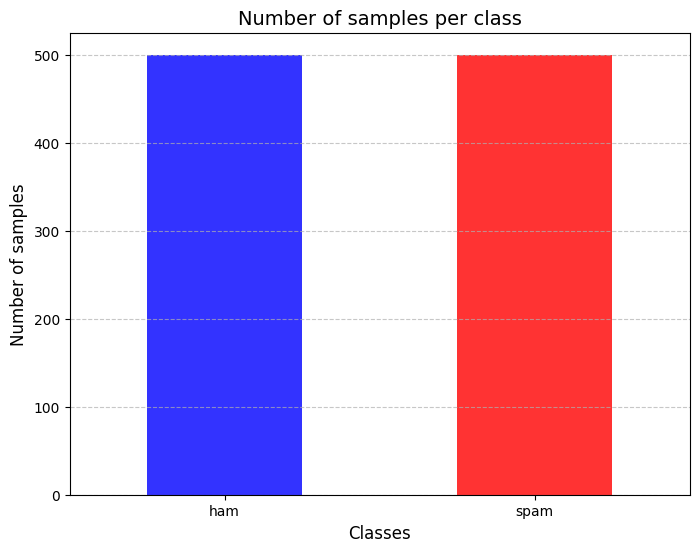

In [3]:
data = pd.read_csv(file_path)
class_counts = data['label'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['blue', 'red'], alpha=0.8)
plt.title('Number of samples per class', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of samples', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 1.2) Data Preprocessing

In [4]:
with open('farsi.txt', 'r', encoding='utf-8') as file:
    persian_stopwords = set(line.strip() for line in file)

def preprocess_text(text):
    text = text.replace("\n", " ")
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\b\d{10,}\b', '', text)
    text = re.sub(r'(.)\1{3,}', r'\1', text)
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in persian_stopwords]
    text = ' '.join(filtered_tokens)

    return text
def preprocess_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+\.\S+', '', text)
    text = re.sub(r'\b\d{10,}\b', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    words = word_tokenize(text)
    text = ' '.join(word for word in words if word not in persian_stopwords)
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text
data['processed_text'] = data['text'].apply(preprocess_text)
print("Some Processed Text")
print(data[['text', 'processed_text']].head(3))

Some Processed Text
                                                text  \
0  ﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...   
1  ﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...   
2  ﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...   

                                      processed_text  
0  ﻿ممنون آقا سامان آزاد شرکت سراسری قبول نشدم می...  
1  ﻿سلام آقای کریمی آزمونارشد تموم شدم یکم راهنما...  
2  ﻿درود حاج وحیدی بنده بعنوان دکتری تاریخ دستی ت...  


## 1.3) Display Feature

In [5]:
data['label'] = pd.factorize(data['label'])[0]

train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['label'])
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])

# ParsBERT
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-zwnj-base")
model = AutoModel.from_pretrained("HooshvareLab/bert-fa-zwnj-base")

def tokenize_and_pad(text, max_length=32):
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    return tokens

train_data['tokens'] = train_data['processed_text'].apply(lambda x: tokenize_and_pad(x, max_length=32))
val_data['tokens'] = val_data['processed_text'].apply(lambda x: tokenize_and_pad(x, max_length=32))
test_data['tokens'] = test_data['processed_text'].apply(lambda x: tokenize_and_pad(x, max_length=32))


def get_embeddings(tokens):
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

train_data['embeddings'] = train_data['tokens'].apply(get_embeddings)
val_data['embeddings'] = val_data['tokens'].apply(get_embeddings)
test_data['embeddings'] = test_data['tokens'].apply(get_embeddings)

pca = PCA(n_components=120)
embeddings = train_data['embeddings'].tolist() + val_data['embeddings'].tolist() + test_data['embeddings'].tolist()
reduced_embeddings = pca.fit_transform(embeddings)
train_data['reduced_embeddings'] = list(reduced_embeddings[:len(train_data)])
val_data['reduced_embeddings'] = list(reduced_embeddings[len(train_data):len(train_data)+len(val_data)])
test_data['reduced_embeddings'] = list(reduced_embeddings[len(train_data)+len(val_data):])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/473M [00:00<?, ?B/s]

## 1.4) Model Implementation

In [6]:
def build_model(learning_rate, optimizer):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=120, input_length=32),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# جستجوی هایپرپارامترها
batch_sizes = [8, 64]
learning_rates = [0.001, 0.0001]
optimizers = ['Adam', 'SGD']

best_model = None
best_val_accuracy = 0
best_learning_rate = 0
best_optimizer = ''
best_batch_size = 0

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for optimizer in optimizers:
            print(f"Training with batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer}")
            model = build_model(learning_rate, optimizer)
            early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
            model.fit(
                x=torch.tensor(train_data['reduced_embeddings'].tolist()),
                y=train_data['label'].values,
                validation_data=(torch.tensor(val_data['reduced_embeddings'].tolist()), val_data['label'].values),
                batch_size=batch_size,
                epochs=10,
                callbacks=[early_stopping],
                verbose=0
            )
            val_acc = model.evaluate(torch.tensor(val_data['reduced_embeddings'].tolist()), val_data['label'].values, verbose=0)[1]
            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                best_model = model
                best_learning_rate = learning_rate
                best_optimizer = optimizer
                best_batch_size = batch_size


print(f"Best hyperparameters: batch_size={best_batch_size}, learning_rate={best_learning_rate}, optimizer={best_optimizer}")

Training with batch_size=8, learning_rate=0.001, optimizer=Adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
<ipython-input-6-dccac5c5dbc8>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x=torch.tensor(train_data['reduced_embeddings'].tolist()),


Training with batch_size=8, learning_rate=0.001, optimizer=SGD
Training with batch_size=8, learning_rate=0.0001, optimizer=Adam
Training with batch_size=8, learning_rate=0.0001, optimizer=SGD
Training with batch_size=64, learning_rate=0.001, optimizer=Adam
Training with batch_size=64, learning_rate=0.001, optimizer=SGD
Training with batch_size=64, learning_rate=0.0001, optimizer=Adam
Training with batch_size=64, learning_rate=0.0001, optimizer=SGD
Best hyperparameters: batch_size=8, learning_rate=0.001, optimizer=Adam


In [7]:
def build_cnn_lstm_model(optimizer=Adam, learning_rate=0.001):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=120, input_length=32),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_model(optimizer=Adam, learning_rate=0.001):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=120, input_length=32),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(optimizer=Adam, learning_rate=0.001):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=120, input_length=32),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model



cnn_model = build_cnn_model(optimizer=globals()[best_optimizer], learning_rate=best_learning_rate)
cnn_model.fit(
    x=np.array(train_data['reduced_embeddings'].tolist()),
    y=train_data['label'].values,
    validation_data=(np.array(val_data['reduced_embeddings'].tolist()), val_data['label'].values),
    batch_size=64,
    epochs=10,
    verbose=1
)

lstm_model = build_lstm_model(optimizer=globals()[best_optimizer], learning_rate=best_learning_rate)
lstm_model.fit(
    x=np.array(train_data['reduced_embeddings'].tolist()),
    y=train_data['label'].values,
    validation_data=(np.array(val_data['reduced_embeddings'].tolist()), val_data['label'].values),
    batch_size=64,
    epochs=10,
    verbose=1
)

cnn_lstm_model = build_cnn_lstm_model(optimizer=globals()[best_optimizer], learning_rate=best_learning_rate)
cnn_lstm_model.fit(
    x=np.array(train_data['reduced_embeddings'].tolist()),
    y=train_data['label'].values,
    validation_data=(np.array(val_data['reduced_embeddings'].tolist()), val_data['label'].values),
    batch_size=64,
    epochs=10,
    verbose=1
)


print("CNN Accuracy: ", cnn_model.evaluate(np.array(test_data['reduced_embeddings'].tolist()), test_data['label'].values)[1])
print("LSTM Accuracy:", lstm_model.evaluate(np.array(test_data['reduced_embeddings'].tolist()), test_data['label'].values)[1])
print("CNN-LSTM Accuracy:", cnn_lstm_model.evaluate(np.array(test_data['reduced_embeddings'].tolist()), test_data['label'].values)[1])

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.4953 - loss: 0.6982 - val_accuracy: 0.5429 - val_loss: 0.6900
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5738 - loss: 0.6831 - val_accuracy: 0.5143 - val_loss: 0.6807
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5996 - loss: 0.6681 - val_accuracy: 0.6643 - val_loss: 0.6633
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7234 - loss: 0.6239 - val_accuracy: 0.7071 - val_loss: 0.6323
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7396 - loss: 0.5561 - val_accuracy: 0.7000 - val_loss: 0.5962
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8210 - loss: 0.4755 - val_accuracy: 0.6786 - val_loss: 0.5825
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8599 - loss: 0.4051 - val_accuracy: 0.7500 - val_loss: 0.5044
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8752 - loss: 0.3133 - val_accuracy: 0.8071 - val_loss: 0.4380


## 1.5) Evaluate

In [8]:
def evaluate_model(model, x_test, y_test):
    predictions = (model.predict(x_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, predictions)
    prec = precision_score(y_test, predictions)
    rec = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, model.predict(x_test))
    return acc, prec, rec, f1, auc

x_test = np.array(test_data['reduced_embeddings'].tolist())
y_test = test_data['label'].values

cnn_metrics = evaluate_model(cnn_model, x_test, y_test)
lstm_metrics = evaluate_model(lstm_model, x_test, y_test)
cnn_lstm_metrics = evaluate_model(cnn_lstm_model, x_test, y_test)

results = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'CNN-LSTM'],
    'Accuracy': [cnn_metrics[0], lstm_metrics[0], cnn_lstm_metrics[0]],
    'Precision': [cnn_metrics[1], lstm_metrics[1], cnn_lstm_metrics[1]],
    'Recall': [cnn_metrics[2], lstm_metrics[2], cnn_lstm_metrics[2]],
    'F1-Score': [cnn_metrics[3], lstm_metrics[3], cnn_lstm_metrics[3]],
    'AUC': [cnn_metrics[4], lstm_metrics[4], cnn_lstm_metrics[4]]
})

print(results)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
      Model  Accuracy  Precision    Recall  F1-Score       AUC
0       CNN  0.853333   0.920635  0.773333  0.840580  0.923067
1      LSTM  0.500000   0.000000  0.000000  0.000000  0.600867
2  CNN-LSTM  0.670000   0.673469  0.660000  0.666667  0.708089


## 1.6) Bounce

In [11]:
vectorizer = CountVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val = vectorizer.transform(val_data['processed_text']).toarray()
X_test = vectorizer.transform(test_data['processed_text']).toarray()

y_train = train_data['label'].values
y_val = val_data['label'].values
y_test = test_data['label'].values

models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging Classifier": BaggingClassifier(),
    "Extra Trees": ExtraTreesClassifier()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    acc = accuracy_score(y_test, predictions)
    prec = precision_score(y_test, predictions)
    rec = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, probabilities) if probabilities is not None else None

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc
    })

results = pd.DataFrame(results)
print(results)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


                 Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Logistic Regression  0.950000   1.000000  0.900000  0.947368  0.991022
1                  SVM  0.886667   0.975410  0.793333  0.875000  0.983867
2        Random Forest  0.943333   0.978417  0.906667  0.941176  0.986778
3          Naive Bayes  0.953333   0.972222  0.933333  0.952381  0.973467
4  K-Nearest Neighbors  0.800000   1.000000  0.600000  0.750000  0.901244
5        Decision Tree  0.920000   0.931507  0.906667  0.918919  0.920000
6             AdaBoost  0.933333   0.985075  0.880000  0.929577  0.975422
7   Bagging Classifier  0.923333   0.970370  0.873333  0.919298  0.978822
8          Extra Trees  0.950000   0.985612  0.913333  0.948097  0.993178
